## Image Captioning 
- Generating automatic captions for images

### Steps
- Data Collection
- Understanding the data
- Data Cleaning
- Loading the training set
- Data Preprocessing- Images
- Data Preprocessing- Captions
- Data Preparation using Generator Function
- Word Embeddings
- Model Architecture
- Inference
- Evaluation

### Step 1: Data Collection

Download the Data from: https://www.kaggle.com/shadabhussain/flickr8k

### Step 2: Understanding the data
- The data contains 8000 images with 4-5 captions for each. 
- Out of this, use:
<ol>
    <li>6000 images for Training</li>
    <li>1000 images for Validation</li>
    <li>2000 images for Testing</li>
</ol>


In [91]:
import pandas as pd
import numpy as np
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50,preprocess_input,decode_predictions
from keras.preprocessing import image
from keras.models import Model,load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input,Dense,Dropout,Embedding,LSTM
from keras.layers.merge import add

In [92]:
#Read Text captions

def readTextFile(path):
    with open(path,encoding='utf-8') as f:
        captions=f.read()
    return captions

In [93]:
captions = readTextFile('dataset/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt')

In [94]:
len(captions.split("\n"))

40460

In [95]:
captions = captions.split("\n")

In [96]:
captions[0:6]

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .',
 '1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting']

In [97]:
first,second=captions[0].split('\t')
print(first,second)

1000268201_693b08cb0e.jpg#0 A child in a pink dress is climbing up a set of stairs in an entry way .


In [98]:
# Create a dictionary to map the captions with Image Id
captions_dict = {}

for x in captions:
    first,second=x.split('\t')
    img_name=first.split('.')[0]
    if captions_dict.get(img_name) is None:
        captions_dict[img_name]=[]
    caption_text=second
    captions_dict[img_name].append(caption_text)  

In [99]:
captions_dict['997722733_0cb5439472']

['A man in a pink shirt climbs a rock face',
 'A man is rock climbing high in the air .',
 'A person in a red shirt climbing up a rock face covered in assist handles .',
 'A rock climber in a red shirt .',
 'A rock climber practices on a rock climbing wall .']

In [100]:
IMG_PATH = 'dataset/Flickr_Data/Flickr_Data/Images/'

In [101]:
import cv2
import matplotlib.pyplot as plt

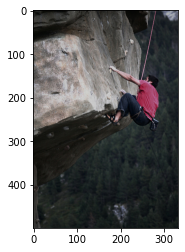

In [102]:
img = cv2.imread(IMG_PATH+"997722733_0cb5439472.jpg")
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

### Step 3. Data Cleaning 

In [103]:
def clean_text(sentence):
    sentence=sentence.lower()
    sentence=re.sub("[^a-z]+"," ",sentence)
    sentence=sentence.split()
    
    sentence=[s for s in sentence if len(s)>1]
    sentence=' '.join(sentence)
    return sentence

In [104]:
clean_text("I am the most amazing women #1")

'am the most amazing women'

In [105]:
# Clean all captions
for key,captions_list in captions_dict.items():
    for i in range(len(captions_list)):
        captions_list[i]=clean_text(captions_list[i])

In [106]:
captions_dict['997722733_0cb5439472']

['man in pink shirt climbs rock face',
 'man is rock climbing high in the air',
 'person in red shirt climbing up rock face covered in assist handles',
 'rock climber in red shirt',
 'rock climber practices on rock climbing wall']

In [107]:
# Write the data into a text file
with open("captions.txt",'w',encoding='utf-8') as f:
    f.write(str(captions_dict))

### Create a vocabulary
- vocabulary: set of all unique words our model can predict

In [108]:
captions_dict = None
with open('captions.txt','r',encoding='utf-8') as f:
    captions_dict=f.read()

json_acceptable_string = captions_dict.replace("'","\"")
captions_dict=json.loads(json_acceptable_string)

In [109]:
print(type(captions_dict))

<class 'dict'>


In [110]:
#Vocab
vocab=set()
for key in captions_dict.keys():
    [vocab.update(sentence.split()) for sentence in captions_dict[key]]

    
print("Vocab Size: %d"%len(vocab))

Vocab Size: 8424


In [111]:
#vocab

In [112]:
# Total no of words across all the sentences 
total_words=[]

for key in captions_dict.keys():
    [total_words.append(i) for capt in captions_dict[key] for i in capt.split()]

print("Total words %d"%len(total_words))

Total words 373837


In [113]:
# Filter words from the Vocab according to certain threshold
import collections
counter = collections.Counter(total_words)
freq_cnt=dict(counter)
print(len(freq_cnt.keys()))

8424


In [114]:
#Sort this dictionary on the basis of freq count
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

#Filter
threshold=10
sorted_freq_cnt=[x for x in sorted_freq_cnt if x[1]>threshold]
print(len(sorted_freq_cnt))
total_words=[x[0] for x in sorted_freq_cnt]
print(len(total_words))

1845
1845


In [115]:
#total_words

### Step 4- Loading the Training and Test Data

In [116]:
train_file_data = readTextFile("dataset/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("dataset/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [117]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [118]:
print(train[:10])
print(test[:10])

['2513260012_03d33305cf', '2903617548_d3e38d7f88', '3338291921_fe7ae0c8f8', '488416045_1c6d903fe0', '2644326817_8f45080b87', '218342358_1755a9cce1', '2501968935_02f2cd8079', '2699342860_5288e203ea', '2638369467_8fc251595b', '2926786902_815a99a154']
['3385593926_d3e9c21170', '2677656448_6b7e7702af', '311146855_0b65fdb169', '1258913059_07c613f7ff', '241347760_d44c8d3a01', '2654514044_a70a6e2c21', '2339106348_2df90aa6a9', '256085101_2c2617c5d0', '280706862_14c30d734a', '3072172967_630e9c69d0']


In [119]:
# Prepare Descp for training data
# Tweak-add start and end token to the training data (<s> and <e> resp)

train_captions={}
for img_id in train:
    train_captions[img_id]=[]
    for capt in captions_dict[img_id]:
        cap_to_append="startseq "+capt +" endseq"
        train_captions[img_id].append(cap_to_append)

In [120]:
train_captions['2513260012_03d33305cf']

['startseq black dog is running after white dog in the snow endseq',
 'startseq black dog chasing brown dog through snow endseq',
 'startseq two dogs chase each other across the snowy ground endseq',
 'startseq two dogs play together in the snow endseq',
 'startseq two dogs running through low lying body of water endseq']

### Transfer Learning
- Images --> Features
- Text --> Features

### Image Feature Extraction

In [121]:
model = ResNet50(weights='imagenet',input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [122]:
model.layers[-2]

In [123]:
model_new = Model(model.input,model.layers[-2].output)

In [124]:
def img_preprocess(img):
    img=image.load_img(img,target_size=(224,224))
    img=image.img_to_array(img)
    img=np.expand_dims(img,axis=0)
    
    #Normalization
    img=preprocess_input(img)
    return img

In [125]:
#img=img_preprocess(IMG_PATH+"997722733_0cb5439472.jpg")
#plt.imshow(img[0])
#plt.axis('off')
#plt.show()

In [126]:
def encode_img(img):
    img=img_preprocess(img)
    feature_vector=model_new.predict(img)
    feature_vector=feature_vector.reshape((-1,))
    return feature_vector

In [127]:
encode_img(IMG_PATH+"997722733_0cb5439472.jpg")

array([0.7995224 , 0.19779338, 0.        , ..., 0.25158167, 0.3302404 ,
       0.17490526], dtype=float32)

### Step 5- Data Preprocessing- Images (Encoding Train and Test Images and Saving them in a file)

In [128]:
encoding_train = {}
#image-id --->(mapped with) feature vector extracted from Resnet Image

start=time()

for ix,img_id in enumerate(train):
    img_path = IMG_PATH+img_id+'.jpg'
    encoding_train[img_id]=encode_img(img_path)
    
    if ix%100==0:
        print('Encoding in progress. Time step %d '%ix)

end=time()
print("Total time taken: ",end-start)
        

Encoding in progress. Time step 0 
Encoding in progress. Time step 100 
Encoding in progress. Time step 200 
Encoding in progress. Time step 300 
Encoding in progress. Time step 400 
Encoding in progress. Time step 500 
Encoding in progress. Time step 600 
Encoding in progress. Time step 700 
Encoding in progress. Time step 800 
Encoding in progress. Time step 900 
Encoding in progress. Time step 1000 
Encoding in progress. Time step 1100 
Encoding in progress. Time step 1200 
Encoding in progress. Time step 1300 
Encoding in progress. Time step 1400 
Encoding in progress. Time step 1500 
Encoding in progress. Time step 1600 
Encoding in progress. Time step 1700 
Encoding in progress. Time step 1800 
Encoding in progress. Time step 1900 
Encoding in progress. Time step 2000 
Encoding in progress. Time step 2100 
Encoding in progress. Time step 2200 
Encoding in progress. Time step 2300 
Encoding in progress. Time step 2400 
Encoding in progress. Time step 2500 
Encoding in progress. Ti

In [129]:
encoding_test = {}
start=time()

for ix,img_id in enumerate(test):
    img_path = IMG_PATH+img_id+'.jpg'
    encoding_test[img_id]=encode_img(img_path)
    
    if ix%100==0:
        print('Encoding in progress. Time step %d '%ix)

end=time()
print("Total time taken: ",end-start)
        

Encoding in progress. Time step 0 
Encoding in progress. Time step 100 
Encoding in progress. Time step 200 
Encoding in progress. Time step 300 
Encoding in progress. Time step 400 
Encoding in progress. Time step 500 
Encoding in progress. Time step 600 
Encoding in progress. Time step 700 
Encoding in progress. Time step 800 
Encoding in progress. Time step 900 
Total time taken:  215.27349472045898


In [130]:
# Store everything to disk
with open('encoded_train_features.pkl','wb') as f:
    pickle.dump(encoding_train,f)
    
with open('encoded_test_features.pkl','wb') as f:
    pickle.dump(encoding_test,f)

### Step 6- Data Preprocessing- Captions (Encoding Train and Test Images and Saving them in a file)

In [131]:
word_2_idx={}
idx_2_word={}

for i,word in enumerate(total_words):
    word_2_idx[word]=i+1
    idx_2_word[i+1]=word

In [132]:
print(word_2_idx['dog'])
print(idx_2_word[6])

6
dog


In [133]:
print(len(idx_2_word))

1845


In [134]:
# Adding 2 special words
idx_2_word[1846]='startseq'
word_2_idx['startseq']=1846

idx_2_word[1847]='endseq'
word_2_idx['endseq']=1847
print("Vocab Size: ",len(word_2_idx)+1)

Vocab Size:  1848


In [135]:
max_len=0
for key in train_captions.keys():
    for capt in train_captions[key]:
        max_len=max(max_len,len(capt.split()))

print(max_len)

35


### Step 7- Data Generator

In [136]:
def data_generator(train_captions,encoded_train,word_2_idx,max_len,batch_size):
    x1,x2,y=[],[],[]
    n=0
    while True:
        for key,capt_list in train_captions.items():
            n+=1
            
            img=encoding_train[key]
            for capt in capt_list:
                seq=[word_2_idx[word] for word in capt.split() if word in word_2_idx]
                for i in range(1,len(seq)):
                    xi=seq[0:i]
                    yi=seq[i]
                    
                    #0 denotes padding word
                    xi=pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi=to_categorical([yi],num_classes=len(word_2_idx)+1)[0]
                    
                    x1.append(img)
                    x2.append(xi)
                    y.append(yi)
                
                if n==batch_size:
                    yield [[np.array(x1),np.array(x2)],np.array(y)]
                    x1,x2,y=[],[],[]
                    n=0

In [137]:
#encoding_train

### Step 8- Word Embeddings

In [138]:
f=open('glove.6B.50d.txt',encoding='utf-8')

In [139]:
embedding_idx={}
for line in f:
    values=line.split()
    word=values[0]
    word_embedding=np.array(values[1:],dtype='float')
    embedding_idx[word]=word_embedding    

In [140]:
embedding_idx['cat']

array([ 0.45281 , -0.50108 , -0.53714 , -0.015697,  0.22191 ,  0.54602 ,
       -0.67301 , -0.6891  ,  0.63493 , -0.19726 ,  0.33685 ,  0.7735  ,
        0.90094 ,  0.38488 ,  0.38367 ,  0.2657  , -0.08057 ,  0.61089 ,
       -1.2894  , -0.22313 , -0.61578 ,  0.21697 ,  0.35614 ,  0.44499 ,
        0.60885 , -1.1633  , -1.1579  ,  0.36118 ,  0.10466 , -0.78325 ,
        1.4352  ,  0.18629 , -0.26112 ,  0.83275 , -0.23123 ,  0.32481 ,
        0.14485 , -0.44552 ,  0.33497 , -0.95946 , -0.097479,  0.48138 ,
       -0.43352 ,  0.69455 ,  0.91043 , -0.28173 ,  0.41637 , -1.2609  ,
        0.71278 ,  0.23782 ])

In [141]:
vocab_size=len(word_2_idx)+1

In [142]:
def get_embedding_matrix():
    emb_dim=50
    matrix=np.zeros((vocab_size,emb_dim))
    for word,idx in word_2_idx.items():
        embedding_vector=embedding_idx.get(word)
        if embedding_vector is not None:
            matrix[idx]=embedding_vector
    
    return matrix

In [143]:
embedding_matrix=get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

In [144]:
embedding_matrix[1847]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### Step 9-Model Architecture

In [145]:
input_img_features=Input(shape=(2048,))
ip_img1=Dropout(0.3)(input_img_features)
ip_img2=Dense(256,activation='relu')(ip_img1)

In [146]:
# Captions as Input
input_captions=Input(shape=(max_len,))
ip_cap1=Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
ip_cap2=Dropout(0.3)(ip_cap1)
ip_cap3=LSTM(256)(ip_cap2)

In [147]:
decoder1=add([ip_img2,ip_cap3])
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)

#Combined Model
model=Model(inputs=[input_img_features,input_captions],outputs=outputs)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       92400       input_6[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_5[0][0]                    
____________________________________________________________________________________________

In [148]:
#Embedding Layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable=False

In [149]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

### Training the Model

In [150]:
epochs=20
batch_size=3
steps=len(train_captions)//batch_size

In [151]:
def train_func():
    for i in range(epochs):
        generator=data_generator(train_captions,encoding_train,word_2_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('./model_weights/model_'+str(i)+'.h5')

In [153]:
# Train the model on google colab

In [157]:
model = load_model('model_weights/model_9.h5')

### Predictions

In [162]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_2_idx[w] for w in in_text.split() if w in word_2_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_2_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

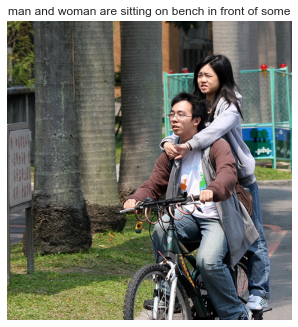

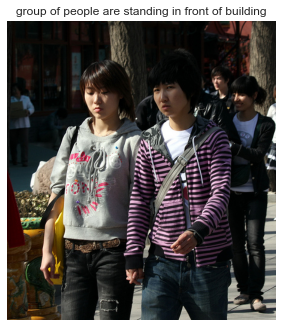

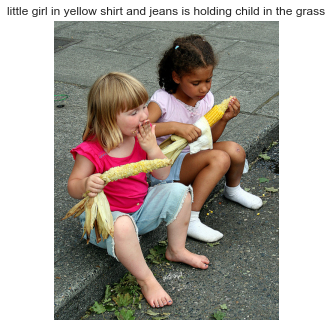

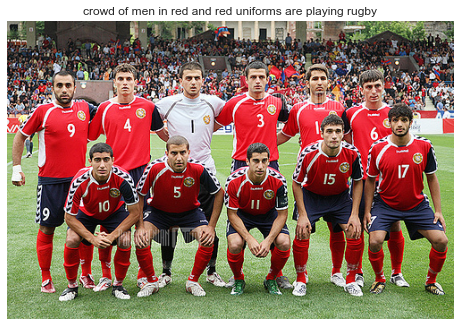

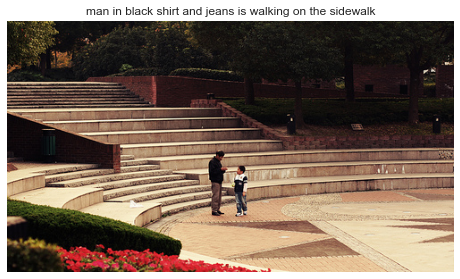

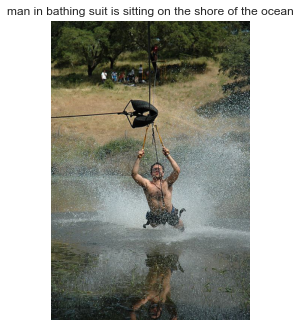

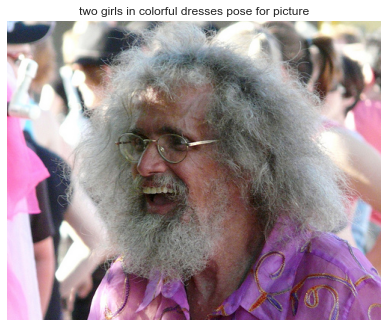

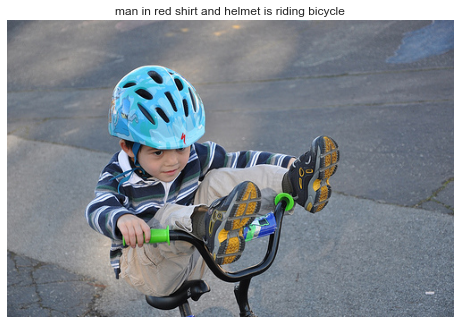

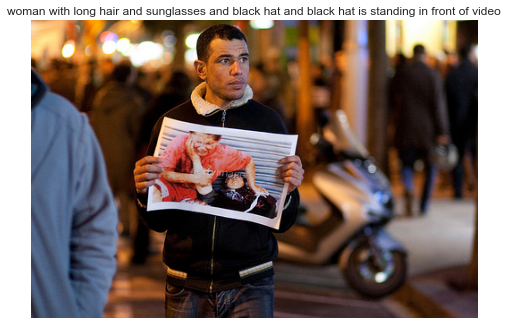

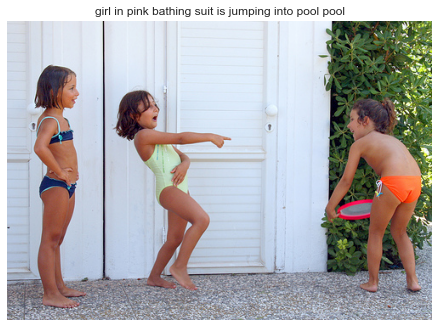

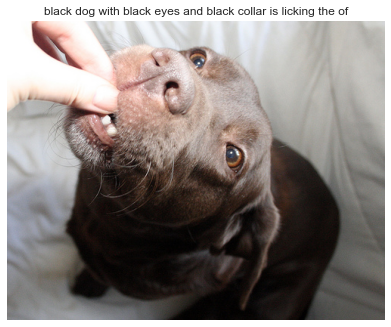

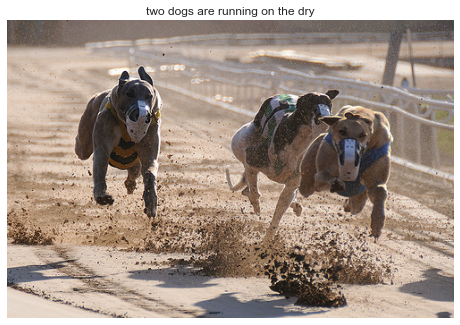

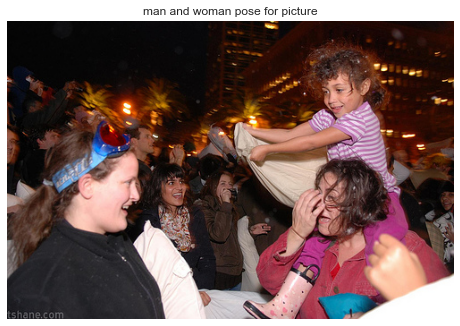

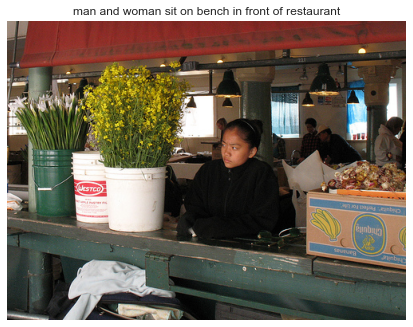

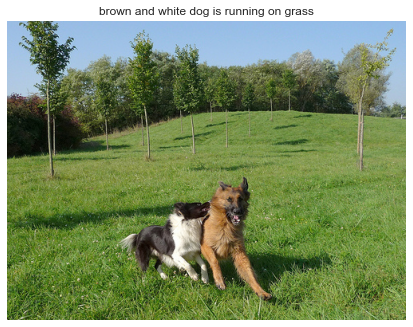

In [164]:
# Pick Some Random Images and See Results
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread(IMG_PATH+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()